# Premier test de postérization de la couleur de l'image

Utilisation de la sgmentation pour donner un coté peinture à l'huile

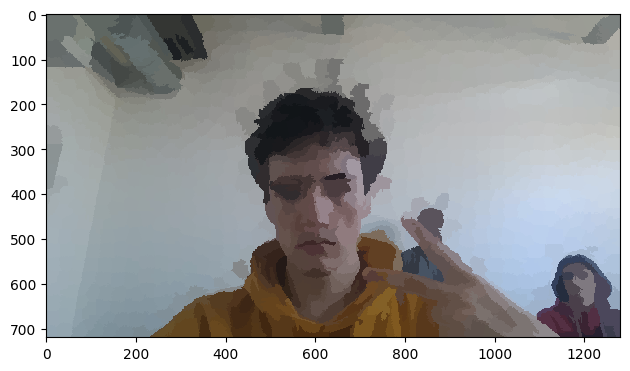

In [19]:
from skimage import data, segmentation, color
from skimage import graph
from skimage import io
from matplotlib import pyplot as plt
from skimage.util import img_as_float

img = img_as_float(io.imread("resources/images/test_1.jpg"))

labels1 = segmentation.slic(img, compactness=2, n_segments=1000, start_label=1)
img_posterized = color.label2rgb(labels1, img, kind='avg', bg_label=0)


io.imshow(img_posterized)

In [20]:
# Tweeks concernatn la coleur

C:\Users\Jame\AppData\Local\Temp\ipykernel_1960\3542155592.py:5: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  filtered_img = filters.gaussian(img, sigma=4)
C:\Users\Jame\AppData\Local\Temp\ipykernel_1960\3542155592.py:9: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  filtered_posterized_image = filters.gaussian(posterized_image, sigma=4)


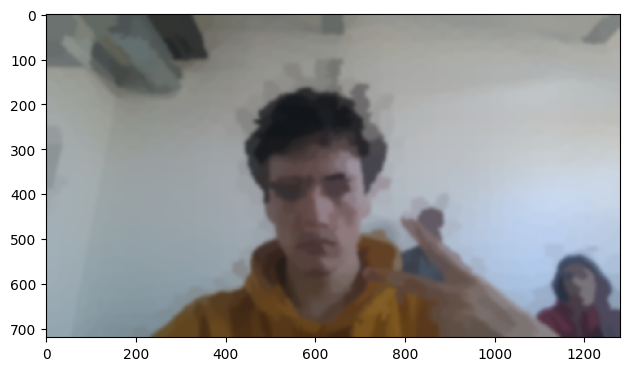

In [38]:
from skimage import filters

img = img_as_float(io.imread("resources/images/test_1.jpg"))

filtered_img = filters.median(img, sigma=4)

labels1 = segmentation.slic(img, compactness=2, n_segments=1000, start_label=1)
posterized_image = color.label2rgb(labels1, filtered_img, kind='avg', bg_label=0)
filtered_posterized_image = filters.gaussian(posterized_image, sigma=4)


io.imshow(filtered_posterized_image)